In [349]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
import seaborn as sns

In [350]:
df_raw = pd.read_pickle('USGS_raw_data.pickle')
df = df_raw.dropna(axis=1, thresh=365*5)
stations = pd.read_pickle('USGS_stations.pickle')

In [351]:
def plotfit(X,y,lr):
    
    plt.subplots(figsize=(10,10))
    ax = plt.subplot(2,2,3)
    plt.scatter(lr.predict(X),y,alpha=0.3,color='black')
    ax.set_xlabel('measured log(turbidity)')
    ax.set_ylabel('predicted log(turbidity)')
    ax.set_title('Measured vs. Predicted',fontweight='bold')
    ax = plt.subplot(2,1,1)
    plt.plot(pd.Series(lr.predict(X),index=y.index),'.')
    plt.plot(y,'.')
    ax.set_xlabel('year')
    ax.set_ylabel('log(turbidity)')
    ax.legend(['measured','predicted'])
    ax.set_title('Time Series Plot',fontweight='bold')
    ax = plt.subplot(2,2,4)
    ax.set_title('Residual Histogram',fontweight='bold')
    ax.set_xlabel('residual')
    ax.set_ylabel('count')
    plt.hist(lr.predict(X)-y,bins=20,color='#999999');

In [352]:
data = df.dropna().apply(np.log)
len(data)

1359

In [559]:
# apply log transformation to all variables
lr = LinearRegression()
data = df.dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(lr.score(X,y))
#plotfit(X,y,lr)

0.795497681407


In [560]:
# find groups of colinear features
d = {}
c = X.corr()
st_list = list(c.columns)
corr_thresh = 0.95

while len(st_list)>0:
    st_key = st_list[0]
    d[st_key] = []
    for st in st_list:
        if c.loc[st,st_key] > corr_thresh:
            d[st_key].append(st)
    for st in d[st_key]:
        st_list.remove(st)

# test each station in each group with multiple stations
d_select = dict.fromkeys(d.keys())

for key in d.keys():
    if len(d[key])>1: # multiple stations
        r2 = 0
        for st in d[key]:
            to_remove = list(d[key])
            to_remove.remove(st)
            lr = LinearRegression()
            Xnew = X.drop(to_remove,axis=1)
            lr.fit(Xnew,y)
            if lr.score(Xnew,y)>r2:
                r2 = lr.score(Xnew,y)
                d_select[key] = (st,r2)

selected = []
for key in d_select.keys():
    if d_select[key] is None:
        selected.append(key)
    else:
        selected.append(d_select[key][0])

# print(selected)


In [561]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE

lr = LinearRegression()
selected.append('turbidity')
data = df[selected].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
# data = df.dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)

X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
# create the RFE model and select 10 attributes
rfe = RFE(lr, 12)
rfe = rfe.fit(X, y)
# # summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)

cols = X.columns[rfe.support_]
group = list(cols)
group.append('turbidity')
# sns.pairplot(df[[<insert the columns of your df here>]])
# sns.heatmap(df[group].corr())     #<---- will give you a good visualization of the correlation matrix

# lr = LinearRegression()
# data = df[group].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# rfe = RFE(lr, 15)
# rfe = rfe.fit(X, y)
# cols = X.columns[rfe.support_]
# group = list(cols)
# group.append('turbidity')

lr = LinearRegression()
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
print(lr.score(X,y))
# plotfit(X,y,lr)

0.590776081315


In [554]:
print('total # of stations: %d'%len(X.columns))
stations.loc[X.columns,'site_name']

total # of stations: 15


03110690      OHIO R AT NEW CUMBERLAND LOCK & DAM (LOWER), OH
03111520         OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV
03430250    CUMBERLAND RIVER AT STONES RIVER NEAR HERMITAG...
03430320     CUMBERLAND RIVER AT BRILEY PKWY NR INGLEWOOD, TN
03431712     CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND
03594500                  TENNESSEE RIVER AT PERRYVILLE, TENN
06090300                   Missouri River near Great Falls MT
06090800                     Missouri River at Fort Benton MT
06342020                          MISSOURI RIVER AT PRICE, ND
06441595              MISSOURI R AT FARM ISLAND NR PIERRE, SD
06813500                           Missouri River at Rulo, NE
06818000                     Missouri River at St. Joseph, MO
07022000                      Mississippi River at Thebes, IL
07374000                 Mississippi River at Baton Rouge, LA
07020850              Mississippi River at Cape Girardeau, MO
Name: site_name, dtype: object

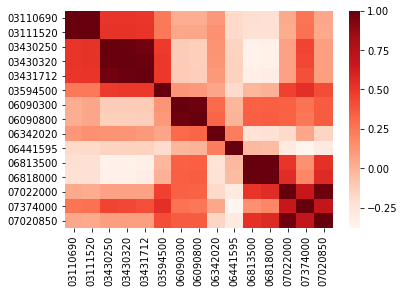

In [527]:
sns.heatmap(X.corr(),cmap='Reds')

In [540]:
# find groups of colinear features
d = {}
c = X.corr()
st_list = list(c.columns)
corr_thresh = 0.9

while len(st_list)>0:
    st_key = st_list[0]
    d[st_key] = []
    for st in st_list:
        if c.loc[st,st_key] > corr_thresh:
            d[st_key].append(st)
    for st in d[st_key]:
        st_list.remove(st)
        
# test each station in each group with multiple stations
d_select = dict.fromkeys(d.keys())

for key in d.keys():
    if len(d[key])>1: # multiple stations
        r2 = 0
        for st in d[key]:
            to_remove = list(d[key])
            to_remove.remove(st)
            lr = LinearRegression()
            Xnew = X.drop(to_remove,axis=1)
            lr.fit(Xnew,y)
            if lr.score(Xnew,y)>r2:
                r2 = lr.score(Xnew,y)
                d_select[key] = (st,r2)
d_select

{'03111520': None,
 '03430320': ('03431712', 0.63273521602606198),
 '03594500': None,
 '06090300': ('06090800', 0.59729804951228971),
 '06342020': None,
 '06441595': None,
 '06818000': None,
 '07022000': ('07022000', 0.62521051672208561),
 '07374000': None}

In [541]:
selected = []
for key in d_select.keys():
    if d_select[key] is None:
        selected.append(key)
    else:
        selected.append(d_select[key][0])

print(selected)

['03111520', '03431712', '03594500', '06090800', '06342020', '06441595', '06818000', '07022000', '07374000']


In [542]:
lr = LinearRegression()
selected.append('turbidity')
data = df[selected].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
lr.fit(X,y)
lr.score(X,y)
# plotfit(X,y,lr)

0.57646178370090606

In [543]:
print('total # of stations: %d'%len(X.columns))
stations.loc[X.columns,'site_name']

total # of stations: 9


03111520        OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV
03431712    CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND
03594500                 TENNESSEE RIVER AT PERRYVILLE, TENN
06090800                    Missouri River at Fort Benton MT
06342020                         MISSOURI RIVER AT PRICE, ND
06441595             MISSOURI R AT FARM ISLAND NR PIERRE, SD
06818000                    Missouri River at St. Joseph, MO
07022000                     Mississippi River at Thebes, IL
07374000                Mississippi River at Baton Rouge, LA
Name: site_name, dtype: object

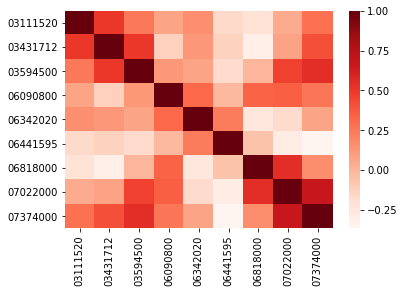

In [544]:
sns.heatmap(X.corr(),cmap='Reds')

In [545]:
Xsm = sm.add_constant(X)
# Create your model and
# Fit your model to your training set
smfit = sm.OLS(y,Xsm).fit()
smfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              turbidity   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     240.8
Date:                Thu, 01 Feb 2018   Prob (F-statistic):          1.83e-289
Time:                        14:45:06   Log-Likelihood:                -1003.0
No. Observations:                1602   AIC:                             2026.
Df Residuals:                    1592   BIC:                             2080.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.4124      2.299    -12.359      0.000     -32.921     -23.903
03111520      -0.1078      0.081     -1.324      0.186      -0.267       0.052
03431712       0.0538      0.139      0.386      0.699      -0.219       0.327
03594500       2.0085      0.377      5.331      0.000       1.269       2.748
06090800      -0.1169      0.045     -2.581      0.010      -0.206      -0.028
06342020       1.7038      0.182      9.360      0.000       1.347       2.061
06441595       2.9785      0.621      4.796      0.000       1.760       4.197
06818000      -0.0935      0.043     -2.165      0.031      -0.178      -0.009
07022000       0.1253      0.036      3.519      0.000       0.055       0.195
07374000       0.8192      0.036     22.947      0.000       0.749       0.889
==============================================================================
Omnibus:                        7.830   Durbin-Watson:                   0.111
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.876
Skew:                          -0.159   Prob(JB):                       0.0195
Kurtosis:                       2.872   Cond. No.                     4.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [548]:
# apply ElasticNet CV on selected features
from sklearn.linear_model import ElasticNetCV

alphas = np.logspace(-2,3,num=20)
ecv = ElasticNetCV(cv=6, alphas=alphas,l1_ratio=1)
data = df[group].dropna().apply(np.log)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(axis=1)
# Note: important here to shuffle
data = data.sample(frac=1)
X = data.drop(['turbidity'],axis=1)
y = data['turbidity']
ecv.fit(X,y)
ecv.score(X,y)


0.51105919047777459

In [553]:
newlist = list(zip(ecv.coef_,stations.loc[X.columns,'site_name']))
for item in newlist:
    print(item)

(0.0, 'OHIO R AT NEW CUMBERLAND LOCK & DAM (LOWER), OH')
(0.0, 'OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV')
(0.0, 'CUMBERLAND RIVER AT STONES RIVER NEAR HERMITAGE,TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY NR INGLEWOOD, TN')
(0.0, 'CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND')
(0.0, 'TENNESSEE RIVER AT PERRYVILLE, TENN')
(0.062854268387548137, 'Missouri River near Great Falls MT')
(0.0, 'Missouri River at Fort Benton MT')
(0.0, 'MISSOURI RIVER AT PRICE, ND')
(0.0, 'MISSOURI R AT FARM ISLAND NR PIERRE, SD')
(-0.0, 'Missouri River at Rulo, NE')
(-0.063768711814306392, 'Missouri River at St. Joseph, MO')
(0.017843099973916282, 'Mississippi River at Thebes, IL')
(0.87625139912599359, 'Mississippi River at Baton Rouge, LA')
(0.0, 'Mississippi River at Cape Girardeau, MO')


In [500]:
print(ecv.coef_[2])

0.0


In [551]:
stations.columns

Index(['watershed', 'site_name', 'lat', 'lon', 'drainage_area_sqmi',
       'gage_datum_ft', 'Turbidity', 'Discharge_start', 'Discharge_end',
       'Discharge_count', 'Gage_start', 'Gage_end', 'Gage_count'],
      dtype='object')

#### <font color='red'> keep the print out below for reference

In [438]:
stations.loc(list(X.columns))

In [442]:
newlist = list(zip(ecv.coef_,stations.loc[X.columns,'site_name']))
for item in newlist:
    print(item)

(-0.14257528699673039, 'OHIO R AT PIKE ISLAND LOCK & DAM (LOWER), WV')
(0.13393877080723182, 'CUMBERLAND RIVER AT BRILEY PKWY AT COCKRILL BEND')
(1.9852575152751604, 'TENNESSEE RIVER AT PERRYVILLE, TENN')
(0.025281000245090973, 'Missouri River near Great Falls MT')
(1.4599583510601462, 'MISSOURI RIVER AT PRICE, ND')
(2.9796264283735585, 'MISSOURI R AT FARM ISLAND NR PIERRE, SD')
(-0.12469916236807262, 'Missouri River at St. Joseph, MO')
(0.10631151310145809, 'Mississippi River at Thebes, IL')
(0.81395289647496316, 'Mississippi River at Baton Rouge, LA')


In [390]:
# # load test data
# df_test = pd.read_pickle('USGS_test_data.pickle')

# lr = LinearRegression()
# data = df_test[selected].dropna().apply(np.log)
# data = data.replace([np.inf, -np.inf], np.nan)
# data = data.dropna(axis=1)
# X = data.drop(['turbidity'],axis=1)
# y = data['turbidity']
# lr.fit(X,y)
# lr.score(X,y)
# plotfit(X,y,lr)
